In [3]:
import netCDF4 as nc
import numpy as np

from scipy import interpolate
import os
from datetime import datetime
import pandas as pd
import csv
import glob

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from pyproj import Proj

In [4]:
sns.set(color_codes=True)
sns.set(style='ticks')
colors = ['faded red', 'bluish', 'faded red', 'bluish']
xkcd = sns.xkcd_palette(colors)
sns.set_palette(xkcd)
#sns.palplot(sns.xkcd_palette(colors))

In [14]:
#ABI_loc = '/localdata/cases/20190403/ABI_tester/'
#GLM_loc = '/localdata/cases/20190403/GLM_tester/'

ABI_loc = '/localdata/cases/test_case/ABI/RadC13/'
GLM_loc = '/localdata/cases/test_case/GLM_grids/'
save_loc = '/localdata/cases/test_case/test_pics/'

In [6]:
#A function that takes in a netCDF Dataset and returns it x/y values as lon/lat
def latlon(nc_file):
    sat_h = nc_file.variables['goes_imager_projection'].perspective_point_height
    sat_lon = nc_file.variables['goes_imager_projection'].longitude_of_projection_origin
    sat_sweep = nc_file.variables['goes_imager_projection'].sweep_angle_axis
    
    X = nc_file.variables['x'][:] * sat_h
    Y = nc_file.variables['y'][:] * sat_h
    
    p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
    XX, YY = np.meshgrid(X, Y)
    lons, lats = p(XX, YY, inverse=True)
    
    return lats,lons

In [15]:
GLM_cutdown = []
ABI_cutdown = []
ABI_complete = []
GLM_complete = []
times = []


for file in sorted(os.listdir(ABI_loc)):
    #Loading in the ABI data
    ABI_data = nc.Dataset(ABI_loc+file, 'r')
    ABI_x = ABI_data.variables['x'][:] 
    ABI_y = ABI_data.variables['y'][:]
    ABI_var = ABI_data.variables['Rad'][:,:]
    ABI_var = np.ma.filled(ABI_var,fill_value=0)
    
    #ABI time stuff
    ABI_time = datetime.strptime(ABI_data.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
    times = np.append(times, ABI_time)
    print (ABI_time)
    YYYY = ABI_time.strftime('%Y')
    mm = ABI_time.strftime('%m') #month
    dd = ABI_time.strftime('%d')
    HH = ABI_time.strftime('%H')
    MM = ABI_time.strftime('%M') #Minute
    
    #Loading in the GLM data
    GLM_file = 'GLM-00-00_'+YYYY+mm+dd+'_'+HH+MM+'00_60_1src_056urad-dx_footprint.nc'
    GLM_data = nc.Dataset(GLM_loc+GLM_file,'r')
    GLM_x = GLM_data.variables['x'][:]
    GLM_y = GLM_data.variables['y'][:]
    GLM_var = np.squeeze(GLM_data.variables['average_flash_area'][:,:]) #Kicks out the time dimension
    GLM_var = np.ma.filled(GLM_var,fill_value=0)
    
    #Matching the ABI grid to the GLM grid
    f = interpolate.interp2d(ABI_y,ABI_x,ABI_var.T, kind='linear')
    ABI_new = f(GLM_y,GLM_x) #Converting TO the GLM coordinates
    
    #Narrowing down to a region of interest
    lats,lons = latlon(GLM_data)
    truth_grid = (lats>38) & (lats<45) & (lons>-110) & (lons<-80)
    GLM_geofocus = GLM_var[truth_grid.T]
    ABI_geofocus = ABI_new[truth_grid.T]
    
    #Flattening variables to 1 dimension
    GLM_flatten = GLM_geofocus.flatten()
    ABI_flatten = ABI_geofocus.flatten()
    
    #Finding where the ABI/GLM data are zero/nonzero
    GLM_zloc = np.where(GLM_flatten==0)[0]
    GLM_nloc = np.where(GLM_flatten>0)[0]
    ABI_zloc = np.where(ABI_flatten==0)[0]
    ABI_nloc = np.where(ABI_flatten>0)[0]
    
    #Adding all nonzero values into the complete dataset
    GLM_complete = np.append(GLM_complete,GLM_flatten[GLM_nloc])
    ABI_complete = np.append(ABI_complete,ABI_flatten[ABI_nloc])
    
    #Applying zeroes from one dataset to another
    ABI_flatten[GLM_zloc] = 0
    GLM_flatten[ABI_zloc] = 0
    
    #Finding the nonzero values from the cutdownvalues
    GLM_n2loc = np.where(GLM_flatten>0)[0]
    
    #Putting the data into their respective cutdown datasets
    GLM_cutdown = np.append(GLM_cutdown,GLM_flatten[GLM_n2loc])
    ABI_cutdown = np.append(ABI_cutdown,ABI_flatten[GLM_n2loc])
    
    ABI_data.close()
    GLM_data.close()
    
    
    #You now have four datasets, both BEFORE and AFTER the cutdown
    

2019-05-27 12:04:16
2019-05-27 12:09:16
2019-05-27 12:14:16
2019-05-27 12:19:16
2019-05-27 12:24:16
2019-05-27 12:29:16
2019-05-27 12:34:16
2019-05-27 12:39:16
2019-05-27 12:44:16
2019-05-27 12:49:16
2019-05-27 12:54:16
2019-05-27 12:59:16
2019-05-27 13:04:16
2019-05-27 13:09:16
2019-05-27 13:14:16
2019-05-27 13:19:16
2019-05-27 13:24:16
2019-05-27 13:29:16
2019-05-27 13:34:16
2019-05-27 13:39:16
2019-05-27 13:44:16
2019-05-27 13:49:16
2019-05-27 13:54:16
2019-05-27 13:59:16
2019-05-27 14:04:16.100000
2019-05-27 14:09:16
2019-05-27 14:14:16.100000
2019-05-27 14:19:16
2019-05-27 14:24:16.100000
2019-05-27 14:29:16.100000
2019-05-27 14:34:16.100000
2019-05-27 14:39:16.100000
2019-05-27 14:44:16.100000
2019-05-27 14:49:16
2019-05-27 14:54:16.100000
2019-05-27 14:59:16.100000
2019-05-27 15:04:16.100000
2019-05-27 15:09:16.100000
2019-05-27 15:14:16.100000
2019-05-27 15:19:16.100000
2019-05-27 15:24:16.100000
2019-05-27 15:29:16.200000
2019-05-27 15:34:16.100000
2019-05-27 15:39:16.100000
2

In [19]:
#Converting everything to 16-bit for memory purposes
ABI_cutdown1 = np.float16(ABI_cutdown)
ABI_complete1 = np.float16(ABI_complete)
GLM_cutdown1 = np.float16(GLM_cutdown)
GLM_complete1 = np.float16(GLM_complete)

#Matching the lengths of the ABI/GLM data so they and be put into a 2-d array
GLM_match = np.ones(len(GLM_complete1)-len(GLM_cutdown1))*np.nan
GLM_append = np.append(GLM_match,GLM_cutdown1)
GLM_final = np.stack((GLM_append,GLM_complete1),axis=1)

ABI_match = np.ones(len(ABI_complete1)-len(ABI_cutdown1))*np.nan
ABI_append = np.append(ABI_match,ABI_cutdown1)
ABI_final = np.stack((ABI_append,ABI_complete1),axis=1)

#Converting the ABI/GLM arrays into pandas dataframe
GLM_pd = pd.DataFrame(GLM_final,columns=['Convective ('+str(len(GLM_cutdown1))+')','Total ('+str(len(GLM_complete1))+')'], dtype='float32')
ABI_pd = pd.DataFrame(ABI_final,columns=['Convective ('+str(len(ABI_cutdown1))+')','Total ('+str(len(ABI_complete1))+')'], dtype='float32')

np.save(save_loc+'AFA.npy',GLM_final)
np.save(save_loc+'Rad13.npy',ABI_final)

del(ABI_cutdown,ABI_complete,GLM_cutdown,GLM_complete)
del(ABI_cutdown1,ABI_complete1,GLM_cutdown1,GLM_complete1)
del(GLM_match,GLM_append,GLM_final)
del(ABI_match,ABI_append,ABI_final)

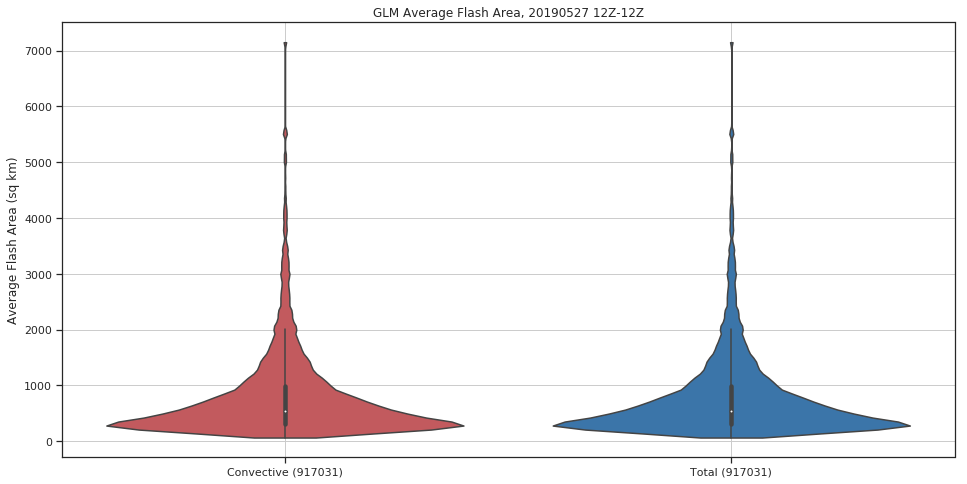

In [17]:
fig1 = plt.figure(figsize=(16, 8))
fig1 = sns.violinplot(data=GLM_pd,cut=0)
plt.title('GLM Average Flash Area, 20190527 12Z-12Z')
plt.ylabel('Average Flash Area (sq km)')
plt.grid(True)
#plt.ylim(0,100)
plt.savefig(save_loc+'AFA.png')
plt.show()

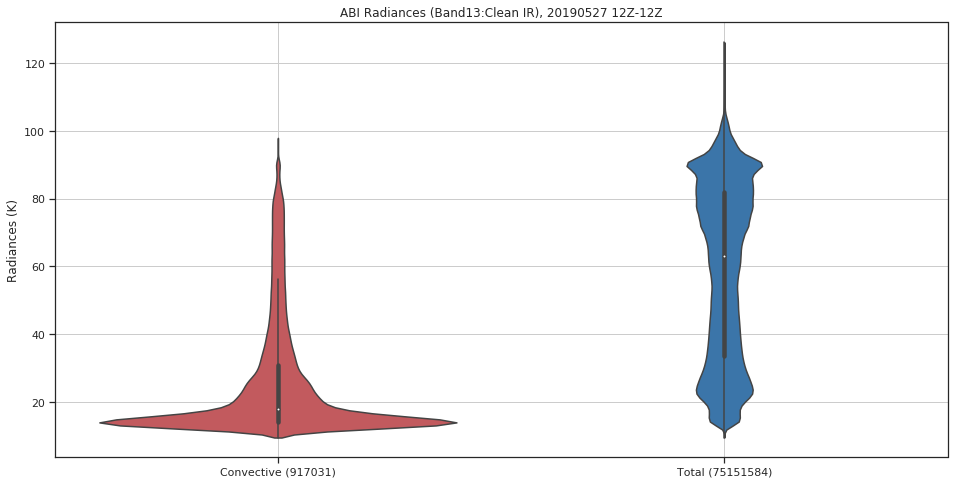

In [18]:
fig1 = plt.figure(figsize=(16, 8))
fig1 = sns.violinplot(data=ABI_pd,cut=0)
plt.title('ABI Radiances (Band13:Clean IR), 20190527 12Z-12Z')
plt.ylabel('Radiances (K)')
plt.grid(True)
plt.savefig(save_loc+'Rad13.png')
plt.show()